In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import itertools
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
# Import the stopwords from NLTK this will help us to filter the most significant words.
nltk.download('stopwords')
pd.options.display.max_colwidth = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlos_barron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Data Load
news_train = pd.read_csv('./data/bbc_news_classification_kaggle/bbc_news_train.csv')
news_test = pd.read_csv('./data/bbc_news_classification_kaggle/bbc_news_test.csv')
documents_train = news_train['Text']
labels_train = news_train['Category']
documents_test = news_test['Text']

# EDA

In [3]:
n_samples = news_train.shape[0]
n_samples

1490

In [4]:
news_train.sample(5)

,ArticleId,Text,Category
295,1550,how to make a greener computer the hi-tech industry is starting to get more environmentally awar...,tech
998,1795,robinson ready for difficult task england coach andy robinson faces the first major test of his ...,sport
882,1901,mcilroy aiming for madrid title northern ireland man james mcilroy is confident he can win his f...,sport
1403,595,roche turns down federer offer australian tennis coach tony roche has turned down an approach ...,sport
931,1024,radcliffe tackles marathon tasks paula radcliffe faces arguably the biggest test of her career i...,sport


### Categories

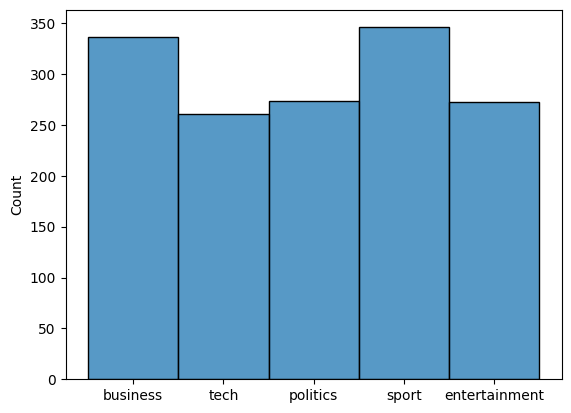

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [5]:
categories_count = news_train['Category'].value_counts()
categories = np.unique(news_train['Category'].values)
sns.histplot(news_train['Category'].values)
plt.show()
categories_count

### Data Cleansing
1. Collect english stopwords from the NLTK library.
2. Remove stopwords from all training documents.
3. Get list of most repeated word by document to be used later for the wordcloud.

In [8]:
stopwords = nltk.corpus.stopwords.words('english') #+ ['us', 'mr', 'said']
documents_train_wo_stopwords = [[re.sub(' +', '', re.sub('[^A-Za-z0-9]+', '', word)).strip() for word in doc.split() if word not in stopwords] for doc in documents_train]
docs_most_common_word = [Counter([re.sub(' +', ' ', re.sub('[^A-Za-z0-9]+', '', word)).strip() for word in doc.split() if word not in stopwords]).most_common(1)[0][0] for doc in documents_train]
documents_train_wo_stopwords = pd.DataFrame([' '.join(doc) for doc in documents_train_wo_stopwords])
documents_train_wo_stopwords.sample(5)

,0
517,moya emotional davis cup win carlos moya described spain davis cup victory highlight career beat...
599,paris promise raises welsh hopes better six nations match saturday epic paris welsh revival cont...
712,moore questions captaincy brian moore believes england captain fullback jason robinson led team ...
171,spirit awards hail sideways comedy sideways dominated year independent spirit awards winning six...
27,henman face saulnier test british number one tim henman face france cyril saulnier first round n...


### Word Statistics by Document
The length of the documents is pretty diverse.

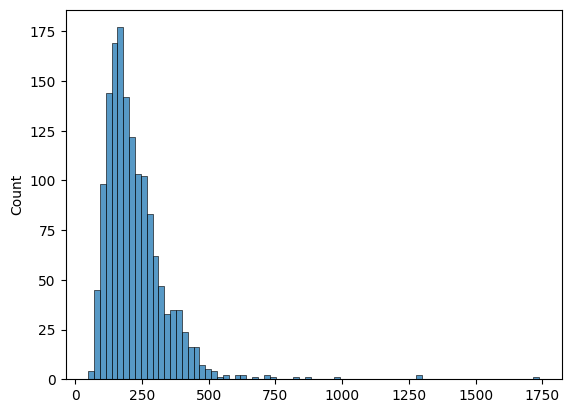

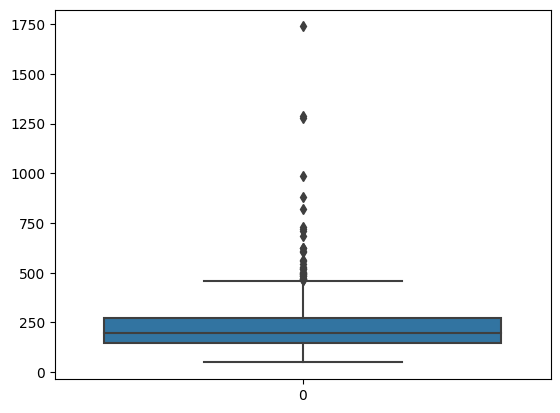

,count,mean,std,min,25%,50%,75%,max
0,1490.0,222.777181,116.51924,49.0,147.0,197.5,272.75,1738.0


In [9]:
word_counts = [d.count(' ') + 1 for d in documents_train_wo_stopwords[0]]
sns.histplot(word_counts)
plt.show()
sns.boxplot(word_counts)
plt.show()
pd.DataFrame(word_counts).describe().T

### Wordcloud
It's very interesting to see the most common words across all of the documents.

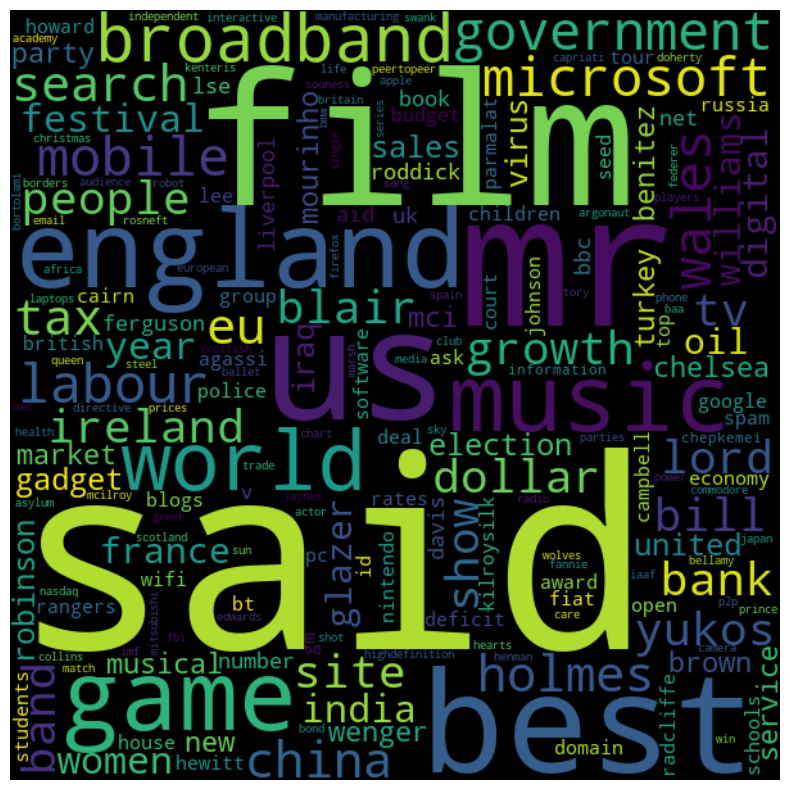

In [10]:
wordcloud = WordCloud(width=600, height=600).generate(' '.join(docs_most_common_word))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [11]:
news_train['most_common_word'] = docs_most_common_word
news_train.sample(5)

,ArticleId,Text,Category,most_common_word
828,1752,foxx and swank win us awards jamie foxx and hilary swank have won the screen actors guild awards...,entertainment,swank
1017,1790,us tv special for tsunami relief a us television network will screen a celebrity tv special to b...,entertainment,aid
190,1264,the producers scoops stage awards the producers has beaten mary poppins in the battle of the blo...,entertainment,
800,670,double win for sea inside spanish movie the sea inside has been named best picture and star javi...,entertainment,best
50,904,telewest to challenge sky plus cable firm telewest is to offer a personal video recorder (pvr) i...,tech,sky


# Feature Extraction
Using sklearn's TfidfVectorizer (Term frequency–inverse document frequency) I will create a vector to collect the most frequent words to compute their occurrences. After testing different parameters the following configuration yielded the best results:
- min_df: Minimum threshold to ignore vocabulary terms based on document frequency.
- max_df: Maximum threshold to ignore vocabulary terms based on document frequency.
- ngram_range: Option (1,1), is for using only unigrams. An n-gram is a contiguous sequence of n items from a given sample of text.
- stopwords: Common words, such as articles, prepositions, conjunctions, and pronouns.

In general TFIDF will provide us with a numerical value to explain how important each word is to each corresponding document.

For the NMF I tried different init values nndsvda gave the best result.
- The init parameter sets the initialization procedure.

In [60]:
# Vectorizer using documents as provided, without any cleansing.
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_train)

In [61]:
nmf = NMF(n_components=len(categories_count), init='nndsvda')
W = nmf.fit_transform(X)
H = nmf.components_

In [62]:
H.shape

(5, 5511)

In [63]:
categories

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [64]:
words = vectorizer.get_feature_names_out()
words

array(['000m', '05', '100', ..., 'zero', 'zone', 'zurich'], dtype=object)

After using the Non-Negative Matrix Factorization method, we have two resulting matrices W and H, that are decomposed from the initial matrix X (TFIDF resulting sparse matrix). 

Below, we can see the 10 most relevant words from each topic. The NMF parameter "number of components" should match the number of categories (business, entertainment, politics, sport, tech) that we want to classify the documents by.

We get the weight of each word by category (topic) from the matrix H, with 5 sorted vectors of weights, and map to the indexes of the features of the tfidf vectorizer.

Then get the argmax of each topic weight from matrix W. This will be our predicted topic, which is numerical, we manually provide the label by briefly analizing the n most important words of each topic or match it using the precision metric that gives the best result (function get_labels below).

Since we are using an unsupervised learning approach, the test dataset will not use any inference from a previous training dataset.

In [65]:
[f'Topic {idx+1}: '+' '.join([words[weight] for weight in weights.argsort()[-10:]]) for idx, weights in enumerate(H)]

['Topic 1: injury season match france club side chelsea ireland cup wales',
 'Topic 2: lib tories tory chancellor tax prime howard party brown blair',
 'Topic 3: broadband net microsoft software digital phones users technology phone mobile',
 'Topic 4: shares rates prices dollar china oil economic sales bank economy',
 'Topic 5: album festival films star oscar band actress actor award awards']

In [66]:
predicted_unlabeled_topics = np.argmax(W, axis=1)+1
predicted_unlabeled_topics

array([4, 4, 4, ..., 4, 3, 3])

In [67]:
def get_labels(y_true, pred_idx, manual_idx=None):
    if manual_idx:
        y_pred = np.vectorize(manual_idx.get)(pred_idx)
        score = accuracy_score(y_true, y_pred)
        return (round(score*100,2), y_pred)
    else:
        permutated_labels = list(itertools.permutations(categories))
        dics = [ {1:l[0], 2:l[1], 3:l[2], 4:l[3], 5:l[4]} for l in permutated_labels]
    best = 0
    result = None
    for dic in dics:
        y_pred = np.vectorize(dic.get)(pred_idx)
        score = accuracy_score(y_true, y_pred)
        if score > best:
            best = score
            result = y_pred
    score = best
    return (round(score*100,2), result)

In [68]:
# Providing a dictionary manually
score, ypred = get_labels(
    labels_train, 
    predicted_unlabeled_topics, 
    manual_idx={1:'sport',2:'politics',3:'tech',4:'business',5:'entertainment'}
)
score

95.77

In [69]:
#Matching against the true labels and getting the best accuracy result.
score, y_pred = get_labels(labels_train, predicted_unlabeled_topics)
score

95.77

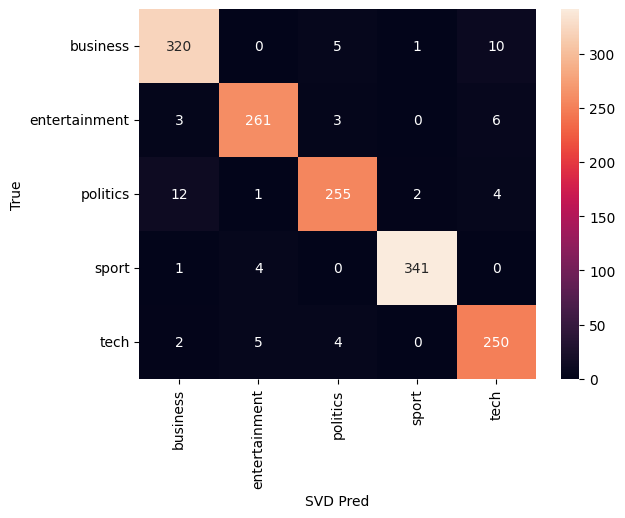

In [75]:
cm = confusion_matrix(labels_train, y_pred)
sns.heatmap(cm, xticklabels=categories, yticklabels=categories,annot=True, fmt='d')
plt.xlabel('SVD Pred')
plt.ylabel('True')
plt.show()

The accuracy of the model with uncleansed documents for the training data is 0.9577

## Using the cleansed training data

In [76]:
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_train_wo_stopwords[0])
nmf = NMF(n_components=len(categories_count), init='nndsvda')
W = nmf.fit_transform(X)
H = nmf.components_
words = vectorizer.get_feature_names_out()
predicted_unlabeled_topics = np.argmax(W, axis=1)+1
[f'Topic {idx+1}: '+' '.join([words[weight] for weight in weights.argsort()[-10:]]) for idx, weights in enumerate(H)]

['Topic 1: broadband net microsoft software phones digital users technology phone mobile',
 'Topic 2: tories tory chancellor prime tax howard party brown election blair',
 'Topic 3: match season coach france club side chelsea ireland cup wales',
 'Topic 4: shares rates prices dollar china oil sales economic bank economy',
 'Topic 5: oscar album star festival films actress band actor award awards']

In [77]:
score, ypred = get_labels(
    labels_train, 
    predicted_unlabeled_topics, 
    manual_idx={1:'tech',2:'politics',3:'sport',4:'business',5:'entertainment'}
)
score

94.36

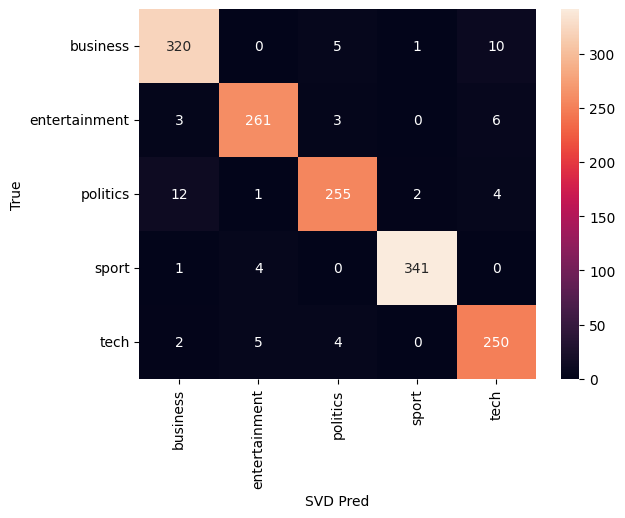

In [78]:
cm = confusion_matrix(labels_train, y_pred)
sns.heatmap(cm, xticklabels=categories, yticklabels=categories,annot=True, fmt='d')
plt.xlabel('SVD Pred')
plt.ylabel('True')
plt.show()

The accuracy of the model with cleansed documents for the training data is 0.9436

Using the cleansed documents without stopwords did not permorm any better.

In [49]:
# Test dataset
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_test)
nmf = NMF(n_components=len(categories_count), init='nndsvda')
W = nmf.fit_transform(X)
H = nmf.components_
words = vectorizer.get_feature_names_out()
predicted_unlabeled_topics = np.argmax(W, axis=1)+1
[f'Topic {idx+1}: '+' '.join([words[weight] for weight in weights.argsort()[-10:]]) for idx, weights in enumerate(H)]

['Topic 1: tv software net phone computer games users digital music mobile',
 'Topic 2: leader tories tax tory prime chancellor howard brown election blair',
 'Topic 3: france coach side rugby ireland injury cup match wales club',
 'Topic 4: shares rate rise china economic oil sales prices bank economy',
 'Topic 5: star actress band oscar prize album festival music awards award']

In [54]:
y_pred = np.vectorize({1:'tech',2:'politics',3:'sport',4:'business',5:'entertainment'}.get)(predicted_unlabeled_topics)
y_pred = pd.DataFrame(y_pred, columns=['Category']).Category
y_pred

0              sport
1               tech
2              sport
3           business
4              sport
           ...      
730         business
731    entertainment
732             tech
733         business
734         politics
Name: Category, Length: 735, dtype: object

In [55]:
y_pred.to_csv('./data/bbc_news_classification_kaggle/predicted.csv',index=False)

# Supervised Appproach
Using Naive Bayes 

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X,labels_train, test_size=0.2)

In [52]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train,Y_train)
y_pred = naive_bayes.predict(X_test)
round(accuracy_score(Y_test, y_pred)*100,2)

96.31